# Lecture 4 -- Semantic Embeddings

## Problems with Ngram Counts

* Considering you need to store a count for every single unique ngram in the text this is a lot of unique items to store, even if you consider stemming, typo-correction, lowercases, etc. As the diversity of your corpus increases, the size of your dataset additionally grows to account for the diversity in word usage
* Any sort of models or plotting we build with ngram counts tend to not generalize to new data too well. there is always exceptions to the rule but think about how language and slang change over time or by area. If we only created our dataset from Seattle discussion in 2019 and tried to apply some downstream model or analysis to Houston in 2023, we might have problems

* THAT SAID, we shouldn't discount them fully. They are _specific_, if we are tracking an ngram, it means that ngram is guarenteed to have been in the corpus and we can find specific references to it

## Semantic Embeddings

* Instead of counting words or ngrams, the state-of-the-art is to create dense embeddings from text

* the basic idea is that "you shall know a word by the company it keeps"
  * https://cmdowney88.github.io/teaching/uw_574/slides/3_WV_GD.pdf

* the foundational paper for this idea was word2vec here:
  * If embeddings aren't familar to you, we recommend reading the following "illustrated version" of word2vec: https://jalammar.github.io/illustrated-word2vec/

* Tempted to add the XKCD fruit plot here too

## Sentence Transformers

* word2vec was one of the first papers and methods to be able to "create a vector given a word"
* modern methods however have scaled this up a lot and its now very common to create semantic vectors for large portions of text

* and this is so common that there is good tooling for extracting these embeddings from text
* `SentenceTransformers` is specifically built to do so

* Let's give sentence transformers a quick try on some example text

In [5]:
from sentence_transformers import SentenceTransformer

# Load the model
model = SentenceTransformer("all-distilroberta-v1")

# Get the semantic embedding for a piece of text
embedding_1 = model.encode("I want to thank UAW4121 for the help in crafting this legislation.")
embedding_1

array([ 2.50484832e-02, -1.92009285e-02, -4.78805862e-02,  6.51347160e-04,
        2.09571924e-02, -5.28855901e-03, -4.59072366e-02,  6.91789994e-03,
        3.56921926e-02, -3.05959675e-02, -4.23887298e-02, -3.55551578e-02,
       -5.04362620e-02, -7.47670755e-02,  2.30247714e-02, -6.62243962e-02,
        2.64527053e-02, -4.07546572e-03, -5.93089014e-02, -8.80574286e-02,
        2.73587238e-02, -7.05565438e-02,  1.83358975e-02,  5.94620453e-03,
        2.17716098e-02, -1.45498561e-02,  5.73872589e-02,  5.97409578e-03,
       -7.05154939e-03,  4.92351055e-02,  7.57808518e-03, -3.72921191e-02,
        1.92622747e-02,  1.67219378e-02, -8.19609407e-03,  1.22744981e-02,
        2.57517528e-02, -3.18145659e-03,  2.65956894e-02, -3.05894744e-02,
        2.17175893e-02, -6.55367086e-03,  1.22397235e-02,  6.47381321e-02,
       -4.17929562e-03, -1.11583276e-02, -2.03686692e-02, -6.04618676e-02,
       -1.84716769e-02,  3.04517746e-02, -1.44924838e-02,  1.44567210e-04,
        3.98083916e-03, -

* embeddings are large dimension vectors!

In [4]:
embedding_1.shape

(768,)

* we can't say for sure what each of these 768 dimensions encode for but we can hopefully show that these embedding vectors include enough information to show how similar two pieces of text are

* to do so, let's embed another piece of text that is similar to original one, but may have different words.

In [15]:
embedding_2 = model.encode("I want to recognize the hard work put in by the Transit Riders Union in assisting in crafting this bill.")
embedding_2.shape

(768,)

In [16]:
from sentence_transformers.util import cos_sim

cos_sim(embedding_1, embedding_2).item()

0.6145123243331909

* This number may not make a lot of sense right now so for comparison, let's try to write a sentence that is very different from the other two and see how similar it is to the other via the embedding

In [17]:
embedding_3 = model.encode("The council is terrible and should be ashamed.")

cos_sim(embedding_1, embedding_3).item(), cos_sim(embedding_2, embedding_3).item()

(0.1019233763217926, 0.15606224536895752)

* TODO: decide to keep this or not

<Axes: >

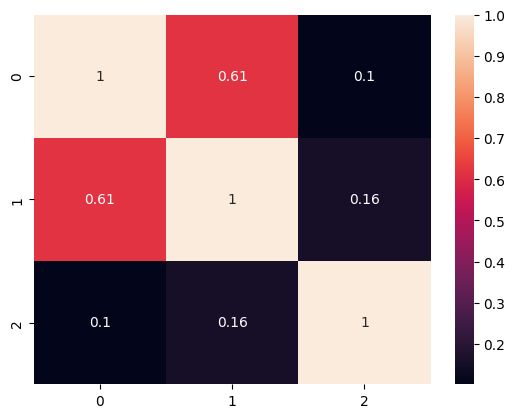

In [64]:
import seaborn as sns
import numpy as np

sim_corpus = []
for embedding_i in [embedding_1, embedding_2, embedding_3]:
    row = []
    for embedding_j in [embedding_1, embedding_2, embedding_3]:
        row.append(cos_sim(embedding_i, embedding_j).item())
    sim_corpus.append(np.stack(row))

sns.heatmap(data=sim_corpus, annot=True)

* when we look at the similarity between embedding 1 or embedding 2 and embedding 3, we notice the "similarity" is much lower.

* the sentences we wrote that we intended to be similar had a cosine similarity of 0.615. And when comparing the sentence that we wrote to try to be different from the other two both were less than 0.156.

* if I was to label the first two examples I might say that the first two were about "thankfullness", "recognition", "legislation", "assistance", etc. the third example was really just "angry"

* And this makes sense, cosine similarity is a metric calcuated between two vectors and results in a value between 0 and 1, with 0 being the exact opposite and 1 being the exact same.

## Semantic Search

* while "keyword search" using ngrams is specific, semantic search relies on the similarity of your query and each document in the corpus

* for example, lets create a fake corpus from possible statements from a council meeting

In [35]:
import pandas as pd

corpus = pd.DataFrame({"text": [
    "Hello my name is Eva and I support this bill",
    "Hello my name is Eva and I do not support this bill",
    "We are not accepting public comments at this time",
    "Welcome to the meeting of the Seattle City Council Transportation Committee",
    "We will have a presentation later on from the Seattle Department of Transportation",
    "I am sorry, could you please explain that slide again",
]})
corpus

,text
0,Hello my name is Eva and I support this bill
1,Hello my name is Eva and I do not support this...
2,We are not accepting public comments at this time
3,Welcome to the meeting of the Seattle City Cou...
4,We will have a presentation later on from the ...
5,"I am sorry, could you please explain that slid..."


* next we can encode all of them to get embeddings

In [46]:
corpus["embedding"] = list(model.encode(corpus.text))
corpus

,text,embedding
0,Hello my name is Eva and I support this bill,"[0.03396301, 0.04418882, -0.03652103, 0.000163..."
1,Hello my name is Eva and I do not support this...,"[0.030697862, 0.05065392, -0.034959856, -0.014..."
2,We are not accepting public comments at this time,"[0.010806136, -0.025713393, -0.00017451386, 0...."
3,Welcome to the meeting of the Seattle City Cou...,"[0.036297053, -0.010011774, -0.034358032, -0.0..."
4,We will have a presentation later on from the ...,"[0.00076063693, -0.016124507, -0.017413434, -0..."
5,"I am sorry, could you please explain that slid...","[-0.03183143, -0.04133318, 0.023597926, 0.0109..."


In [71]:
query_embedding = model.encode("transportation presentation")

corpus["similarity"] = corpus.embedding.apply(lambda stored_embed: cos_sim(query_embedding, stored_embed).item())
corpus.sort_values(by="similarity", ascending=False)

,text,embedding,similarity
4,We will have a presentation later on from the ...,"[0.00076063693, -0.016124507, -0.017413434, -0...",0.575698
3,Welcome to the meeting of the Seattle City Cou...,"[0.036297053, -0.010011774, -0.034358032, -0.0...",0.425648
5,"I am sorry, could you please explain that slid...","[-0.03183143, -0.04133318, 0.023597926, 0.0109...",0.272697
0,Hello my name is Eva and I support this bill,"[0.03396301, 0.04418882, -0.03652103, 0.000163...",0.086764
1,Hello my name is Eva and I do not support this...,"[0.030697862, 0.05065392, -0.034959856, -0.014...",0.071163
2,We are not accepting public comments at this time,"[0.010806136, -0.025713393, -0.00017451386, 0....",0.070965


* we can see that even though none of the sentences contain the specific words "transportation presentation" the three sentences about having a presentation from the transporation department, welcoming the audience to the transportation committee, and finally asking for clarification on a slide, are all the top three most similar sentences

* keyword matches are great and are needed for specificity but semantic embeddings and cosine similarity enable generalized search

## Semantic Neighborhoods

* Remember the XKCD plot of fruits? we can try to do something similar with two dimensions at a time

In [80]:
for i, embedding_dim in enumerate(model.encode(corpus.text).T):
    corpus[f"embedding_dim_{i}"] = embedding_dim

corpus = corpus.copy()
corpus = corpus.reset_index()
corpus["index"] = corpus["index"].astype(str)

,level_0,index,text,embedding,similarity,embedding_dim_0,embedding_dim_1,embedding_dim_2,embedding_dim_3,embedding_dim_4,...,embedding_dim_758,embedding_dim_759,embedding_dim_760,embedding_dim_761,embedding_dim_762,embedding_dim_763,embedding_dim_764,embedding_dim_765,embedding_dim_766,embedding_dim_767
0,0,0,Hello my name is Eva and I support this bill,"[0.03396301, 0.04418882, -0.03652103, 0.000163...",0.086764,0.033963,0.044189,-0.036521,0.000163,-0.022653,...,-0.005820,-0.046426,-0.019358,0.014870,0.014184,0.065651,0.161757,0.007610,-0.047574,-0.021437
1,1,1,Hello my name is Eva and I do not support this...,"[0.030697862, 0.05065392, -0.034959856, -0.014...",0.071163,0.030698,0.050654,-0.034960,-0.014841,-0.009940,...,0.007570,-0.040500,-0.033636,0.002352,0.018580,0.056462,0.136450,-0.006366,-0.055677,-0.032537
2,2,2,We are not accepting public comments at this time,"[0.010806136, -0.025713393, -0.00017451386, 0....",0.070965,0.010806,-0.025713,-0.000175,0.008182,-0.058773,...,0.019821,0.045061,-0.022289,-0.019493,0.050189,-0.001603,0.090009,-0.030414,-0.066751,0.015786
3,3,3,Welcome to the meeting of the Seattle City Cou...,"[0.036297053, -0.010011774, -0.034358032, -0.0...",0.425648,0.036297,-0.010012,-0.034358,-0.003031,0.037832,...,0.026945,-0.019815,-0.009853,-0.033627,-0.034199,0.027400,-0.045490,0.024472,-0.020053,-0.046001
4,4,4,We will have a presentation later on from the ...,"[0.00076063693, -0.016124507, -0.017413434, -0...",0.575698,0.000761,-0.016125,-0.017413,-0.024016,0.023628,...,0.038259,0.005103,-0.044730,-0.021341,-0.008436,-0.011500,0.002520,-0.002502,0.003777,-0.044913
5,5,5,"I am sorry, could you please explain that slid...","[-0.03183143, -0.04133318, 0.023597926, 0.0109...",0.272697,-0.031831,-0.041333,0.023598,0.010960,-0.010069,...,0.021068,0.039313,-0.009426,0.002631,0.002912,-0.024525,0.001060,-0.050434,-0.034723,-0.007274


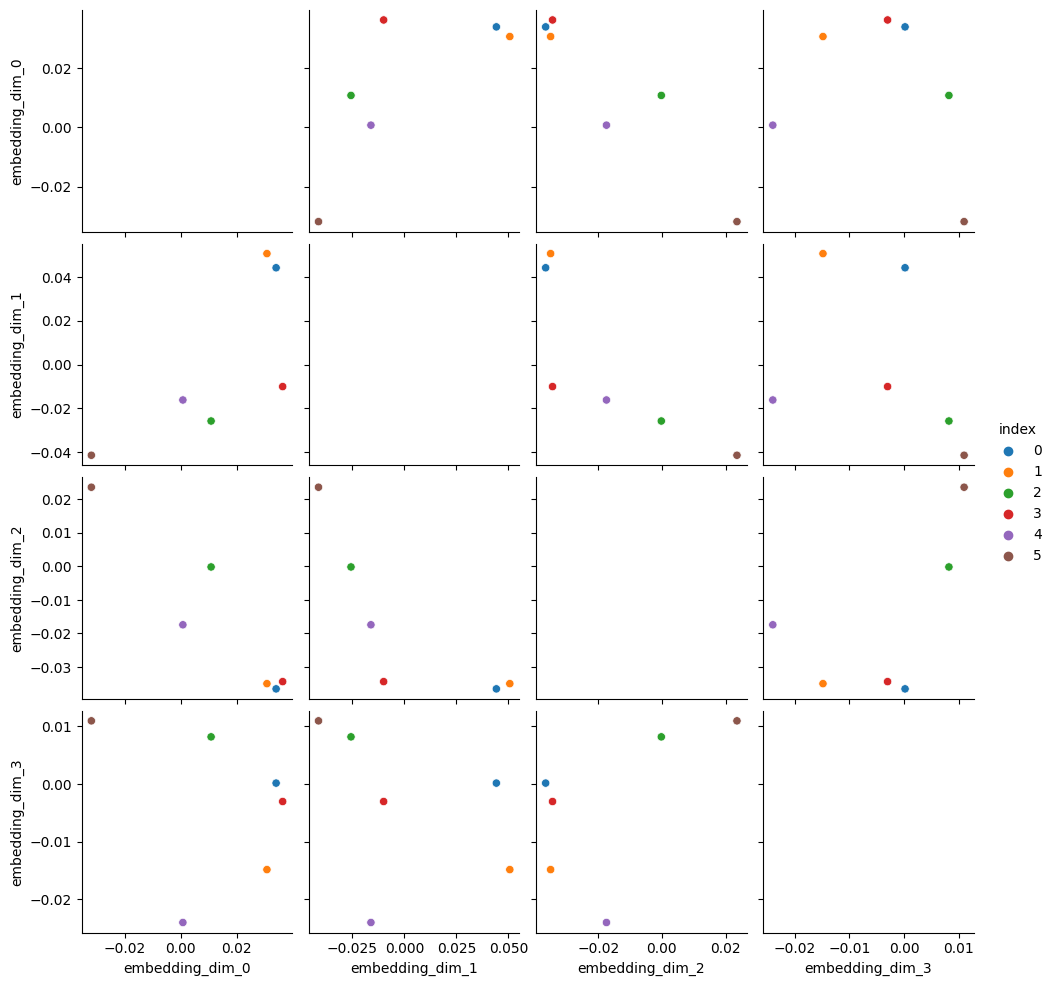

In [88]:
sns.pairplot(data=corpus[["index", "embedding_dim_0", "embedding_dim_1", "embedding_dim_2", "embedding_dim_3"]], hue="index")

* With 768 dimensions we very quickly start to lose track of what each dimension may encode
* fortunately there are tools that try to downsample all of these dimensions down to just 2 for plotting purposes

### UMAP